## Loading Dataset, importing Libraries

In [ ]:
#!pip install -U sentence-transformers


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import chain
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
import joblib

In [ ]:
df = pd.read_csv("/clinvar_variants.csv")
print(df.shape)
print(df.columns)

(10381, 24)
Index(['Unnamed: 0', 'Name', 'Gene(s)', 'Protein change', 'Condition(s)',
       'Accession', 'GRCh37Location', 'GRCh38Location', 'VariationID',
       'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type',
       'Molecular consequence', 'Germline classification',
       'Germline date last evaluated', 'Germline review status',
       'Somatic clinical impact',
       'Somatic clinical impact date last evaluated',
       'Somatic clinical impact review status', 'Oncogenicity classification',
       'Oncogenicity date last evaluated', 'Oncogenicity review status',
       'Unnamed: 24'],
      dtype='object')


In [ ]:
print(df.isna().sum())

Unnamed: 0                                         0
Name                                               0
Gene(s)                                            0
Protein change                                  6036
Condition(s)                                       2
Accession                                          0
GRCh37Location                                    79
GRCh38Location                                  1306
VariationID                                        0
AlleleID(s)                                        0
dbSNP ID                                        2414
Canonical SPDI                                  1726
Variant type                                       0
Molecular consequence                           1699
Germline classification                            0
Germline date last evaluated                     120
Germline review status                             0
Somatic clinical impact                        10379
Somatic clinical impact date last evaluated   

## Dataset cleaning - remove useless columns

In [ ]:
nullcols =  ['Germline review status','Germline date last evaluated',"Somatic clinical impact","Somatic clinical impact date last evaluated","Somatic clinical impact review status","Oncogenicity classification","Oncogenicity date last evaluated","Oncogenicity review status","Unnamed: 24","Unnamed: 0"]

In [ ]:
df.drop(columns =nullcols , inplace = True)

In [ ]:
print(df.columns)

Index(['Name', 'Gene(s)', 'Protein change', 'Condition(s)', 'Accession',
       'GRCh37Location', 'GRCh38Location', 'VariationID', 'AlleleID(s)',
       'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence',
       'Germline classification'],
      dtype='object')


In [ ]:
df.head()

,Name,Gene(s),Protein change,Condition(s),Accession,GRCh37Location,GRCh38Location,VariationID,AlleleID(s),dbSNP ID,Canonical SPDI,Variant type,Molecular consequence,Germline classification
0,Single allele,LOC130068431|LOC130068432|LOC130068480|LOC1300...,NaN,Autism|Schizophrenia,VCV000488014,NaN,1 - 156040895,488014,481029,NaN,NaN,Duplication,NaN,Pathogenic
1,GRCh38/hg38 Xp22.33-q28(chrX:10001-156030895)x1,KLHL13|KLHL15|KLHL34|KLHL4|KRBOX4|L1CAM|L1CAM-...,NaN,See cases,VCV000146764,60001 - 155260560,10001 - 156030895,146764,156515,NaN,NaN,copy number loss,NaN,Pathogenic
2,GRCh38/hg38 Xp22.33-q28(chrX:10679-156013167)x1,LOC126863269|LOC126863270|LOC126863271|LOC1268...,NaN,See cases,VCV000160983,60679 - 155242832,10679 - 156013167,160983,170827,NaN,NaN,copy number loss,NaN,Pathogenic
3,GRCh38/hg38 Xp22.33-q28(chrX:10679-156022206)x3,LOC130068436|LOC130068437|LOC130068438|LOC1300...,NaN,See cases,VCV000160897,60679 - 155251871,10679 - 156022206,160897,170741,NaN,NaN,copy number gain,NaN,Pathogenic
4,GRCh38/hg38 Xp22.33-q28(chrX:10679-156022206)x1,CSAG1|CSAG2|CSAG3|CSF2RA|CSTF2|CT45A1|CT45A10|...,NaN,See cases,VCV000160890,60679 - 155251871,10679 - 156022206,160890,170734,NaN,NaN,copy number loss,NaN,Pathogenic


In [ ]:
print("Unique Values")
for i in df.columns:
  print(i,":",len(df[i].unique()))

Unique Values
Name : 10284
Gene(s) : 187
Protein change : 4324
Condition(s) : 417
Accession : 10381
GRCh37Location : 8713
GRCh38Location : 7663
VariationID : 10381
AlleleID(s) : 10381
dbSNP ID : 6892
Canonical SPDI : 8656
Variant type : 11
Molecular consequence : 60
Germline classification : 11


## Understanding the label

In [ ]:
df["Germline classification"].value_counts()

,count
Germline classification,
Likely benign,3052
Pathogenic,2737
Uncertain significance,2672
Conflicting classifications of pathogenicity,639
Likely pathogenic,518
Benign,484
Benign/Likely benign,156
Pathogenic/Likely pathogenic,114
not provided,5


In [ ]:
df = df[
    (df["Germline classification"] != "not provided") &
    (df["Germline classification"] != "conflicting data from submitters") &
    (df["Germline classification"] != "no classification for the single variant")
]


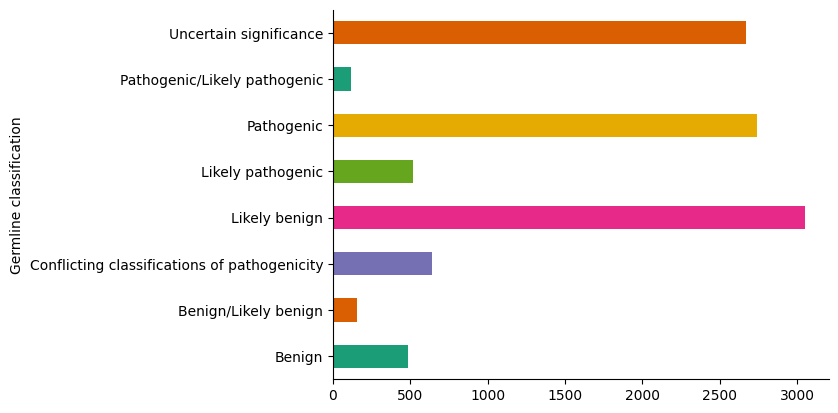

In [ ]:
# @title Germline Classification

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Germline classification').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Understanding Individual features

In [ ]:
df.columns

Index(['Name', 'Gene(s)', 'Protein change', 'Condition(s)', 'Accession',
       'GRCh37Location', 'GRCh38Location', 'VariationID', 'AlleleID(s)',
       'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence',
       'Germline classification'],
      dtype='object')

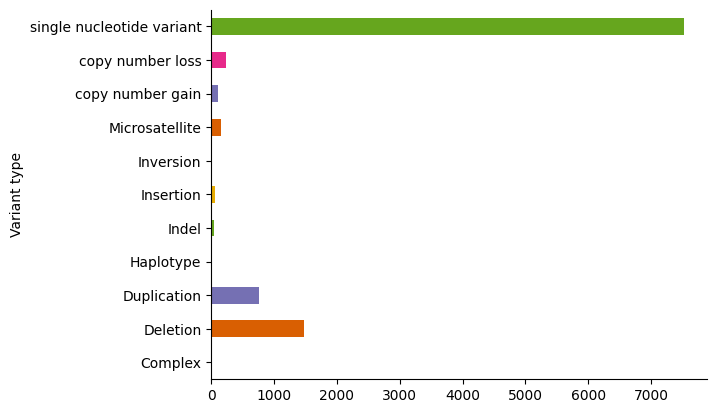

In [ ]:
# @title Variant distribution
df.groupby('Variant type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

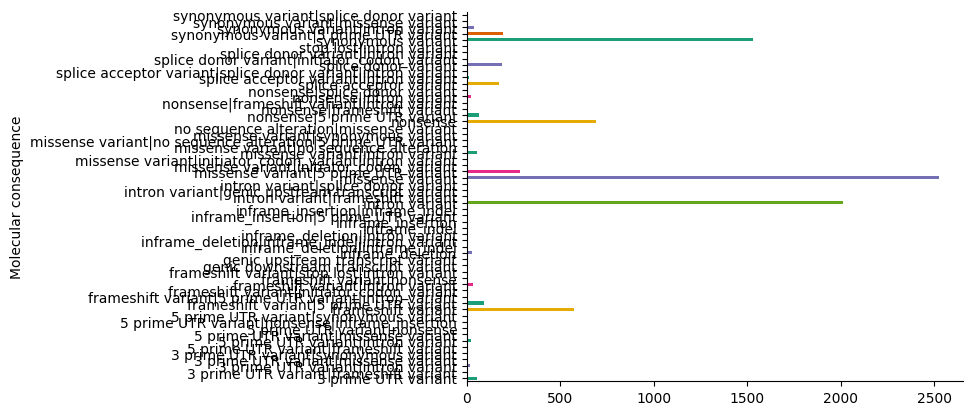

In [ ]:
# @title Molecular consequence distribution
df.groupby('Molecular consequence').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df['Condition(s)'].value_counts()

,count
Condition(s),
Duchenne muscular dystrophy,5939
not provided,1176
Duchenne muscular dystrophy|not provided,310
not provided|Duchenne muscular dystrophy,283
Cardiovascular phenotype,259
...,...
Duchenne muscular dystrophy|Duchenne muscular dystrophy|Becker muscular dystrophy|Dilated cardiomyopathy 3B|Cardiovascular phenotype,1
not provided|Duchenne muscular dystrophy|Cardiovascular phenotype|Dilated cardiomyopathy 3B|not specified,1
not provided|Qualitative or quantitative defects of dystrophin|Cardiomyopathy|Ptosis|Proptosis|Clinodactyly of the 5th finger|Pectus excavatum|not specified|Becker muscular dystrophy|Duchenne muscular dystrophy|Dilated cardiomyopathy 3B|Cardiovascular phenotype|Becker muscular dystrophy|Duchenne muscular dystrophy,1


In [ ]:
print(df["Gene(s)"].value_counts())

Gene(s)
DMD                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
print(df["Canonical SPDI"].value_counts())

Canonical SPDI
NC_000023.11:33340621:T:C                                                                          1
NC_000023.11:23617261:AAGC:|NC_000023.11:31168033:CCATGGGGA:ACATTAGCCCATGTCAGAAATTTCTAACATTAGCC    1
NC_000023.11:31119333:A:C                                                                          1
NC_000023.11:31119355:C:T                                                                          1
NC_000023.11:31119590:C:T                                                                          1
                                                                                                  ..
NC_000023.11:31120213:T:C                                                                          1
NC_000023.11:31120187:T:G                                                                          1
NC_000023.11:31120157:TGAATGAATGA:TGAATGA                                                          1
NC_000023.11:31120135:T:C                                                   

In [ ]:
print(df["dbSNP ID"].value_counts())

dbSNP ID
rs200540950     5
rs72467955      4
rs35286502      4
rs1324314201    3
rs771389805     3
               ..
rs72468603      1
rs2534071875    1
rs2534071827    1
rs2534071744    1
rs2534072993    1
Name: count, Length: 6889, dtype: int64


In [ ]:
print(df["Accession"].value_counts())

Accession
VCV000011208    1
VCV000488014    1
VCV000146764    1
VCV000160983    1
VCV000992228    1
               ..
VCV000146239    1
VCV000148018    1
VCV000148051    1
VCV000148082    1
VCV000160890    1
Name: count, Length: 10372, dtype: int64


In [ ]:
df["Protein change"].value_counts()

,count
Protein change,
C10fs,3
"S88fs, S92fs, S96fs",2
"W2020*, W2135*, W2139*, W2143*, W799*, W802*",2
"E345fs, E460fs, E464fs, E468fs",2
"I165fs, I169fs, I173fs, I50fs",2
...,...
"Y2092*, Y751*, Y2084*, Y2088*, Y748*, Y1969*",1
"D2086N, D753N, D1971N, D2094N, D2090N, D750N",1
"R2095*, R2087*, R754*, R1972*, R751*, R2091*",1


### Imputing / dropping null values

In [ ]:
df['Protein change'].fillna('unknown', inplace=True)
most_common_mc = df['Molecular consequence'].mode()[0]
df['Molecular consequence'].fillna(most_common_mc, inplace=True)
df['Canonical SPDI'].fillna('unknown:unknown:unknown:unknown', inplace=True)
df['dbSNP ID'].fillna('rs0', inplace=True)  # "rs0" as sentinel for missing
# Fill missing GRCh37 with GRCh38 if available
df['GRCh37Location'].fillna(df['GRCh38Location'], inplace=True)
# Fill missing GRCh38 with GRCh37 if available
df['GRCh38Location'].fillna(df['GRCh37Location'], inplace=True)
df.dropna(subset=['Gene(s)', 'Variant type' ,'GRCh37Location','GRCh38Location' ], inplace=True)  # critical features

/tmp/ipython-input-140-1352161020.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Protein change'].fillna('unknown', inplace=True)
/tmp/ipython-input-140-1352161020.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [ ]:
print(df.isna().sum(), df.shape)

Name                       0
Gene(s)                    0
Protein change             0
Condition(s)               0
Accession                  0
GRCh37Location             0
GRCh38Location             0
VariationID                0
AlleleID(s)                0
dbSNP ID                   0
Canonical SPDI             0
Variant type               0
Molecular consequence      0
Germline classification    0
dtype: int64 (10323, 14)


## Pre processing individual features

In [ ]:
def split_pipe_values(df, col):
    # Replace NaNs with empty string to avoid errors
    df[col] = df[col].fillna("")
    # Split pipe-separated strings into lists
    return df[col].str.split("|")
# Apply to all relevant columns
df["Gene_list"] = split_pipe_values(df, "Gene(s)")
df["Condition_list"] = split_pipe_values(df, "Condition(s)")
df["Consequence_list"] = split_pipe_values(df, "Molecular consequence")
df["Allele_list"] = split_pipe_values(df, "AlleleID(s)")

In [ ]:
# Flatten and get unique genes
unique_genes = set(chain.from_iterable(df["Gene_list"]))
unique_conditions = set(chain.from_iterable(df["Condition_list"]))
unique_consequences = set(chain.from_iterable(df["Consequence_list"]))
unique_alleles = set(chain.from_iterable(df["Allele_list"]))

print("Unique Genes:", len(unique_genes))
print("Unique Conditions:", len(unique_conditions))
print("Unique Consequences:", len(unique_consequences))
print("Unique Alleles:", len(unique_alleles))

Unique Genes: 2639
Unique Conditions: 77
Unique Consequences: 17
Unique Alleles: 10324


In [ ]:
# Split comma-separated values into lists
df["Protein_change_list"] = df["Protein change"].str.split(", ")

# Optional: Explode for per-protein-change-level stats
df_protein_exp = df.explode("Protein_change_list")

# Count common mutations
top_changes = df_protein_exp["Protein_change_list"].value_counts().head(20)
df['has_fs'] = df['Protein change'].str.contains('fs').astype(int)
df['has_stop'] = df['Protein change'].str.contains('\*').astype(int)
df['n_protein_changes'] = df['Protein_change_list'].apply(len)

In [ ]:
# Ensure proper format and fill NAs if needed
df["GRCh37Location"] = df["GRCh37Location"].fillna("chr?:?-?")
df["Chromosome"] = df["GRCh37Location"].str.extract(r'^(\w+):')
df["Start_Pos"] = df["GRCh37Location"].str.extract(r':(\d+)-').astype(float)
df["End_Pos"] = df["GRCh37Location"].str.extract(r'-(\d+)$').astype(float)

# Compute length (if End - Start is meaningful)
df["Variant_Length"] = df["End_Pos"] - df["Start_Pos"]
scaler = MinMaxScaler()
df[["Start_Pos", "End_Pos", "Variant_Length"]] = scaler.fit_transform(
    df[["Start_Pos", "End_Pos", "Variant_Length"]]
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [ ]:
# Normalize continuous IDs
df[['VariationID']] = scaler.fit_transform(df[['VariationID']])

# CUSTOM LLM-based embeddings using BioBERT

In [ ]:

# Load optimized BioBERT model for sentence embeddings
model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")  # Optimized biomedical embedder

# Choose your device automatically (GPU if available)
device = 'cuda' if model.device.type == 'cuda' else 'cpu'
print(f"Using device: {device}")

# List of columns to embed
embed_cols = ["Canonical SPDI", "Name", "Protein change", "Accession"]

# Convert NaNs to placeholder and make lists of text inputs
for col in embed_cols:
    df[col] = df[col].fillna("unknown").astype(str)

# Function to embed a column using fast batching
def batch_embed_column(text_list, col_name):
    print(f"\nEmbedding column: {col_name}")
    embeddings = model.encode(text_list, batch_size=64, show_progress_bar=True, device=device)
    embedding_df = pd.DataFrame(embeddings, columns=[f"{col_name}_llm_{i}" for i in range(embeddings.shape[1])])
    return embedding_df

# Apply to all selected columns
embedding_frames = []
for col in embed_cols:
    embedding_frames.append(batch_embed_column(df[col].tolist(), col))

# Concatenate all embeddings
df_embed = pd.concat(embedding_frames, axis=1)
df_final = pd.concat([df.reset_index(drop=True), df_embed.reset_index(drop=True)], axis=1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using device: cpu

Embedding column: Canonical SPDI


Batches:   0%|          | 0/162 [00:00<?, ?it/s]


Embedding column: Name


Batches:   0%|          | 0/162 [00:00<?, ?it/s]


Embedding column: Protein change


Batches:   0%|          | 0/162 [00:00<?, ?it/s]


Embedding column: Accession


Batches:   0%|          | 0/162 [00:00<?, ?it/s]

# Model 1 - Deep learning (CNN approach)

In [ ]:
# Load the .parquet file
df = pd.read_parquet("clinvar_dmd_embeddings.parquet")

# Check the target classes
print("Target classes:", df["Germline classification"].unique())

Target classes: ['Pathogenic' 'Uncertain significance' 'Benign' 'Likely benign'
 'Conflicting classifications of pathogenicity' 'Benign/Likely benign'
 'Likely pathogenic' 'Pathogenic/Likely pathogenic']


In [ ]:
le_target = LabelEncoder()
df["target"] = le_target.fit_transform(df["Germline classification"])


In [ ]:
joblib.dump(le_target, "label_encoder_germline.pkl")

['label_encoder_germline.pkl']

In [ ]:
categoricalcols = [x for x in df.columns if df[x].dtype == object]
numericcols = [x for x in df.columns if x not in categoricalcols ]
print(categoricalcols,numericcols,sep = "\n")

['Name', 'Gene(s)', 'Protein change', 'Condition(s)', 'Accession', 'GRCh37Location', 'GRCh38Location', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Molecular consequence', 'Germline classification', 'Gene_list', 'Condition_list', 'Consequence_list', 'Allele_list', 'Protein_change_list']
['VariationID', 'Variant type', 'has_fs', 'has_stop', 'n_protein_changes', 'Chromosome', 'Start_Pos', 'End_Pos', 'Variant_Length', 'Canonical SPDI_llm_0', 'Canonical SPDI_llm_1', 'Canonical SPDI_llm_2', 'Canonical SPDI_llm_3', 'Canonical SPDI_llm_4', 'Canonical SPDI_llm_5', 'Canonical SPDI_llm_6', 'Canonical SPDI_llm_7', 'Canonical SPDI_llm_8', 'Canonical SPDI_llm_9', 'Canonical SPDI_llm_10', 'Canonical SPDI_llm_11', 'Canonical SPDI_llm_12', 'Canonical SPDI_llm_13', 'Canonical SPDI_llm_14', 'Canonical SPDI_llm_15', 'Canonical SPDI_llm_16', 'Canonical SPDI_llm_17', 'Canonical SPDI_llm_18', 'Canonical SPDI_llm_19', 'Canonical SPDI_llm_20', 'Canonical SPDI_llm_21', 'Canonical SPDI_llm_22', 'Canonical SPDI

In [ ]:
categorical_cols = [
    "Variant type",
    "Molecular consequence",
]
le = LabelEncoder()
for col in categorical_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])
        joblib.dump(le, f"label_encoder_{col.replace(' ', '_')}.pkl")


In [ ]:
joblib.dump(le_target, "label_encoder_germline.pkl")
joblib.dump(le, f"label_encoder_{col.replace(' ', '_')}.pkl")

['label_encoder_Chromosome.pkl']

In [ ]:
# Keep only embedding + selected features
embed_cols = [col for col in df.columns if "_llm_" in col]
num_cols = ["Start_Pos", "End_Pos", "Variant_Length", "has_fs", "has_stop", "n_protein_changes"]
selected_features = embed_cols + num_cols + categorical_cols

In [ ]:
X = df[selected_features].fillna(0).values
y = df["target"].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

train_ds = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
val_ds = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

In [ ]:
class DMDClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], num_classes=8):
        super(DMDClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.bn3 = nn.BatchNorm1d(hidden_dims[2])
        self.dropout3 = nn.Dropout(0.3)

        self.out = nn.Linear(hidden_dims[2], num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        return self.out(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DMDClassifier(input_dim=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def evaluate(model, val_loader):
    model.eval()
    correct, total = 0, 0
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        with torch.no_grad():
            preds = model(xb)
            predicted = torch.argmax(preds, dim=1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    return correct / total

# Training loop
for epoch in range(15):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Val Accuracy: {acc:.4f}")


Epoch 1 | Loss: 0.5689 | Val Accuracy: 0.7205
Epoch 2 | Loss: 1.5362 | Val Accuracy: 0.7424
Epoch 3 | Loss: 0.6746 | Val Accuracy: 0.7527
Epoch 4 | Loss: 1.0225 | Val Accuracy: 0.7508
Epoch 5 | Loss: 0.3852 | Val Accuracy: 0.7495
Epoch 6 | Loss: 1.8407 | Val Accuracy: 0.7624
Epoch 7 | Loss: 0.2947 | Val Accuracy: 0.7637
Epoch 8 | Loss: 1.3235 | Val Accuracy: 0.7482
Epoch 9 | Loss: 0.1734 | Val Accuracy: 0.7508
Epoch 10 | Loss: 0.8843 | Val Accuracy: 0.7644
Epoch 11 | Loss: 1.1516 | Val Accuracy: 0.7534
Epoch 12 | Loss: 1.0882 | Val Accuracy: 0.7566
Epoch 13 | Loss: 0.6787 | Val Accuracy: 0.7521
Epoch 14 | Loss: 0.1853 | Val Accuracy: 0.7637
Epoch 15 | Loss: 1.2400 | Val Accuracy: 0.7598


In [ ]:
torch.save(model.state_dict(), "dmd_classifier_model.pt")

# Model 2 - Optimized NN approach with class weights

In [ ]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
best_val_acc = 0.0
patience = 5
patience_counter = 0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def get_predictions(model, loader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            all_preds.extend(torch.argmax(output, axis=1).cpu().numpy())
            all_targets.extend(yb.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)


In [ ]:
for epoch in range(50):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation step
    val_acc = evaluate(model, val_loader)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Loss: {total_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_dmd_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


Epoch 01 | Train Loss: 137.6377 | Val Acc: 0.5558
Epoch 02 | Train Loss: 121.9124 | Val Acc: 0.6520
Epoch 03 | Train Loss: 112.4276 | Val Acc: 0.6294
Epoch 04 | Train Loss: 102.8591 | Val Acc: 0.6262
Epoch 05 | Train Loss: 90.9883 | Val Acc: 0.6850
Epoch 06 | Train Loss: 86.5126 | Val Acc: 0.6708
Epoch 07 | Train Loss: 75.7361 | Val Acc: 0.6824
Epoch 08 | Train Loss: 78.7114 | Val Acc: 0.6643
Epoch 09 | Train Loss: 73.1818 | Val Acc: 0.6624
Epoch 10 | Train Loss: 62.5285 | Val Acc: 0.6895
Epoch 11 | Train Loss: 53.7159 | Val Acc: 0.6888
Epoch 12 | Train Loss: 52.6626 | Val Acc: 0.7101
Epoch 13 | Train Loss: 48.2848 | Val Acc: 0.7114
Epoch 14 | Train Loss: 47.8105 | Val Acc: 0.7050
Epoch 15 | Train Loss: 45.2644 | Val Acc: 0.7121
Epoch 16 | Train Loss: 45.9329 | Val Acc: 0.6940
Epoch 17 | Train Loss: 41.0797 | Val Acc: 0.7179
Epoch 18 | Train Loss: 38.9951 | Val Acc: 0.7224
Epoch 19 | Train Loss: 43.3012 | Val Acc: 0.7101
Epoch 20 | Train Loss: 42.1304 | Val Acc: 0.6966
Epoch 21 | Train

In [ ]:
# Load best model
model.load_state_dict(torch.load("best_dmd_model.pt"))

preds, targets = get_predictions(model, val_loader)

# Evaluation
print("\nClassification Report:")
print(classification_report(targets, preds, target_names=le_target.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(targets, preds))

try:
    y_probs = torch.softmax(torch.tensor([model(torch.tensor(x).float().to(device)).detach().cpu().numpy() for x in X_val]), dim=2).squeeze(0).numpy()
    print("\nROC AUC (macro):", roc_auc_score(y_val, y_probs, multi_class="ovr", average="macro"))
except:
    print("Unable to compute ROC AUC")



Classification Report:
                                              precision    recall  f1-score   support

                                      Benign       0.69      0.61      0.65        72
                        Benign/Likely benign       0.15      0.30      0.20        23
Conflicting classifications of pathogenicity       0.50      0.50      0.50        96
                               Likely benign       0.88      0.81      0.84       458
                           Likely pathogenic       0.26      0.47      0.33        76
                                  Pathogenic       0.86      0.76      0.81       407
                Pathogenic/Likely pathogenic       0.11      0.24      0.15        17
                      Uncertain significance       0.78      0.75      0.77       400

                                    accuracy                           0.72      1549
                                   macro avg       0.53      0.56      0.53      1549
                            

In [ ]:
merge_map = {
    "Benign/Likely benign": "Benign",
    "Pathogenic/Likely pathogenic": "Pathogenic",
    "Conflicting classifications of pathogenicity": "Uncertain significance"
}
df["Germline classification"] = df["Germline classification"].replace(merge_map)


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return torch.mean(focal_loss) if self.reduction == 'mean' else focal_loss

# Replace criterion
criterion = FocalLoss(alpha=class_weights_tensor, gamma=2.0)

In [ ]:
# Load the best model
model.load_state_dict(torch.load("best_dmd_model.pt"))
model.eval()

# Pick a row from validation set
idx = 15  # Change to any index sample - 20 (wrong) , 15 (correct )

sample = torch.tensor(X_val[idx]).float().to(device).unsqueeze(0)

# Predict
with torch.no_grad():
    output = model(sample)
    pred_class = torch.argmax(output, dim=1).item()
    pred_label = le_target.inverse_transform([pred_class])[0]
print(f"Selected sample:\n {df.iloc[idx][:20]}")
print(f"Predicted class: {pred_label}")
print(f"True class     : {le_target.inverse_transform([y_val[idx]])[0]}")


Selected sample:
 Name                         GRCh38/hg38 Xp22.33-q28(chrX:10679-156022206)x3
Gene(s)                    LOC126863254|LOC126863255|LOC126863256|LOC1268...
Protein change                                                       unknown
Condition(s)                                                       See cases
Accession                                                       VCV000057086
GRCh37Location                                             60679 - 155251871
GRCh38Location                                             10679 - 156022206
VariationID                                                         0.011796
AlleleID(s)                                                            71681
dbSNP ID                                                                 rs0
Canonical SPDI                               unknown:unknown:unknown:unknown
Variant type                                                               8
Molecular consequence                                     

# Preprocessing new variants and predictions

In [ ]:
import torch
import pandas as pd
import numpy as np
import os
from sentence_transformers import SentenceTransformer

# Load saved BioBERT model once globally
biobert_model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")  # Or use model name directly

# Load trained PyTorch model
model_path = "best_dmd_model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# You must define DMDClassifier class here again or import it
model = DMDClassifier(input_dim=3080).to(device)  # Adjust input_dim based on your features
model.load_state_dict(torch.load(model_path))
model.eval()

# LabelEncoder must be loaded or reused from training
le_target = joblib.load("label_encoder_germline.pkl")

def batch_embed_column(text_list, col_name):
    print(f"Embedding column: {col_name}")
    embeddings = biobert_model.encode(
        text_list, batch_size=64, show_progress_bar=False,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    return pd.DataFrame(embeddings, columns=[f"{col_name}_llm_{i}" for i in range(embeddings.shape[1])])
def generate_llm_embeddings(df, columns_to_embed):
    df = df.copy()
    for col in columns_to_embed:
        df[col] = df[col].fillna("unknown").astype(str)

    embedding_frames = [batch_embed_column(df[col].tolist(), col) for col in columns_to_embed]
    return pd.concat([df.reset_index(drop=True)] + embedding_frames, axis=1)

def predict_new_variant(sample_dict):
    """
    Predict the germline classification of a single variant sample.

    Required keys:
    - Canonical SPDI, Name, Protein change, Accession
    - Start_Pos, End_Pos, Variant_Length, has_fs, has_stop, n_protein_changes, Variant type, Chromosome
    """

    # --- Validate ---
    llm_cols = ["Canonical SPDI", "Name", "Protein change", "Accession"]
    structured_cols = ['Start_Pos', 'End_Pos', 'Variant_Length', 'has_fs', 'has_stop',
                       'n_protein_changes', 'Variant type', 'Chromosome']
    missing = [col for col in (llm_cols + structured_cols) if col not in sample_dict]
    if missing:
        raise ValueError(f"Missing required fields: {missing}")

    # --- Convert to DataFrame ---
    df = pd.DataFrame([sample_dict])

    # --- Encode categorical structured features ---
    # (assuming you used LabelEncoder previously on these during training)
    # --- Encode categorical structured features ---
    for col in ['Variant type', 'Chromosome']:
        if col in df.columns:
            df[col] = df[col].astype(str)
            le_path = f"label_encoder_{col.replace(' ', '_')}.pkl"
            if os.path.exists(le_path):
                le_struct = joblib.load(le_path)
                if df[col].iloc[0] not in le_struct.classes_:
                    # Handle unseen category
                    print(f"Warning: unseen category '{df[col].iloc[0]}' in '{col}'. Setting to 'unknown' or fallback.")
                    df[col] = -1  # or use the most frequent label: le_struct.transform([le_struct.classes_[0]])
                else:
                    df[col] = le_struct.transform(df[col])
            else:
                raise FileNotFoundError(f"Missing LabelEncoder file for column: {col}")


    # --- Embed text columns ---
    df = generate_llm_embeddings(df, llm_cols)

    # --- Select features in same order as model ---
    llm_features = [col for col in df.columns if "_llm_" in col]
    final_features = structured_cols + llm_features
    X = df[final_features].fillna(0).values.astype(np.float32)

    # --- Model prediction ---
    model.eval()
    input_tensor = torch.tensor(X).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        pred_label = le_target.inverse_transform([pred_class])[0]

    return pred_label

In [ ]:
print([x for x in selected_features if "_llm_" not in x])

['Start_Pos', 'End_Pos', 'Variant_Length', 'has_fs', 'has_stop', 'n_protein_changes', 'Variant type', 'Chromosome']
0        0
1        0
2        0
3        0
4        0
        ..
10318    0
10319    0
10320    0
10321    0
10322    0
Name: Chromosome, Length: 10323, dtype: int64


In [ ]:
new_variant = {
    "Canonical SPDI": "NC_000023.10:31130762:A:T",
    "Name": "c.100A>T",
    "Protein change": "p.Lys34Asn",
    "Accession": "NM_004006.2",
    "Start_Pos": 31130762,
    "End_Pos": 31130762,
    "Variant_Length": 1,
    "has_fs": 0,
    "has_stop": 0,
    "n_protein_changes": 1,
    "Variant type": "single nucleotide variant"
}

prediction = predict_new_variant(new_variant)
print("Prediction:", prediction)


Embedding column: Canonical SPDI
Embedding column: Name
Embedding column: Protein change
Embedding column: Accession
Prediction: Uncertain significance


# Model 3 - using complex features with multilabelbinarizer

In [ ]:
class DMDMultiInputModel(nn.Module):
    def __init__(self,
                 llm_dim=768*4,
                 structured_dim=8,
                 gene_vocab_size=2640,
                 cond_vocab_size=80,
                 cons_vocab_size=20,
                 allele_vocab_size=10325,
                 output_dim=8):
        super().__init__()

        self.gene_embed = nn.Embedding(gene_vocab_size, 64, padding_idx=0)
        self.cond_embed = nn.Embedding(cond_vocab_size, 32, padding_idx=0)
        self.cons_embed = nn.Embedding(cons_vocab_size, 16, padding_idx=0)
        self.allele_embed = nn.Embedding(allele_vocab_size, 64, padding_idx=0)

        self.llm_fc = nn.Linear(llm_dim, 256)
        self.struct_fc = nn.Linear(structured_dim, 64)

        # Final classifier input = 256 + 64 + 64 + 32 + 16 + 64 = 496
        self.final_fc = nn.Sequential(
            nn.Linear(496, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim)
        )

    def forward(self, llm_x, struct_x, gene_ids, cond_ids, cons_ids, allele_ids):
        gene_vec = self.gene_embed(gene_ids).mean(dim=1)
        cond_vec = self.cond_embed(cond_ids).mean(dim=1)
        cons_vec = self.cons_embed(cons_ids).mean(dim=1)
        allele_vec = self.allele_embed(allele_ids).mean(dim=1)

        llm_feat = F.relu(self.llm_fc(llm_x))
        struct_feat = F.relu(self.struct_fc(struct_x))

        x = torch.cat([llm_feat, struct_feat, gene_vec, cond_vec, cons_vec, allele_vec], dim=1)
        return self.final_fc(x)


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_gene = MultiLabelBinarizer()
gene_mhot = mlb_gene.fit_transform(df['Gene_list'])

mlb_condition = MultiLabelBinarizer()
condition_mhot = mlb_condition.fit_transform(df['Condition_list'])

mlb_consequence = MultiLabelBinarizer()
consequence_mhot = mlb_consequence.fit_transform(df['Consequence_list'])

mlb_allele = MultiLabelBinarizer()
allele_mhot = mlb_allele.fit_transform(df['Allele_list'])

# Concatenate to main feature set
X = np.concatenate([X_base, gene_mhot, condition_mhot, consequence_mhot, allele_mhot], axis=1)
